In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [32]:
import os

In [33]:
print("started")

started


In [34]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,ReLU , MaxPooling2D, Rescaling, Reshape, Dropout, BatchNormalization, AveragePooling2D, Input, RandomFlip, RandomRotation, Concatenate
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import torch
import torch.nn.functional as F

from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Module

import torch.optim as optim
from torch.utils.data import DataLoader

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

In [37]:
CLASS = 7
batch_size = 32
img_height = 64
img_width = 64
train_dir = os.path.join("C:/Users/Diana/Desktop/data_set_ana/train")
test_dir = os.path.join("C:/Users/Diana/Desktop/data_set_ana/test")
CLASS, batch_size, (img_height, img_width), train_dir, test_dir

(7,
 32,
 (64, 64),
 'C:/Users/Diana/Desktop/data_set_ana/train',
 'C:/Users/Diana/Desktop/data_set_ana/test')

In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
#     color_mode="grayscale",
    label_mode="categorical",
    interpolation="area",
    validation_split=0.01,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
train_ds, train_ds.class_names

Found 28709 files belonging to 7 classes.
Using 28422 files for training.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

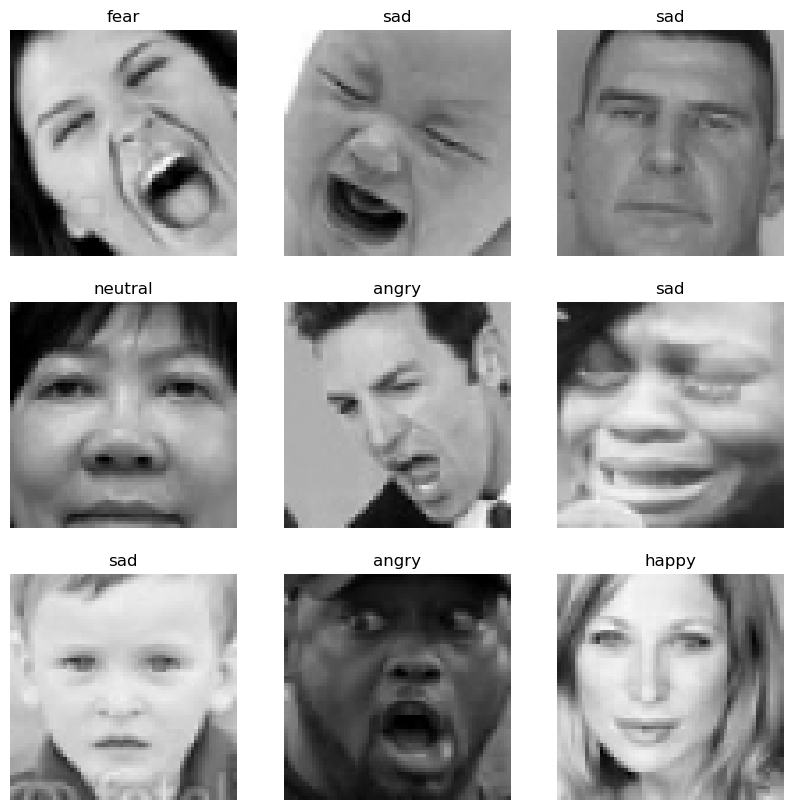

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
#     plt.title(train_ds.class_names[labels[i]])
    plt.title(train_ds.class_names[np.argmax(labels[i])])
#     print(np.argmax(labels[i]))
    plt.axis("off")

In [40]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
#     color_mode="grayscale",
    label_mode="categorical",
    interpolation="area",
    validation_split=0.99,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
test_ds, test_ds.class_names

Found 7178 files belonging to 7 classes.
Using 7106 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

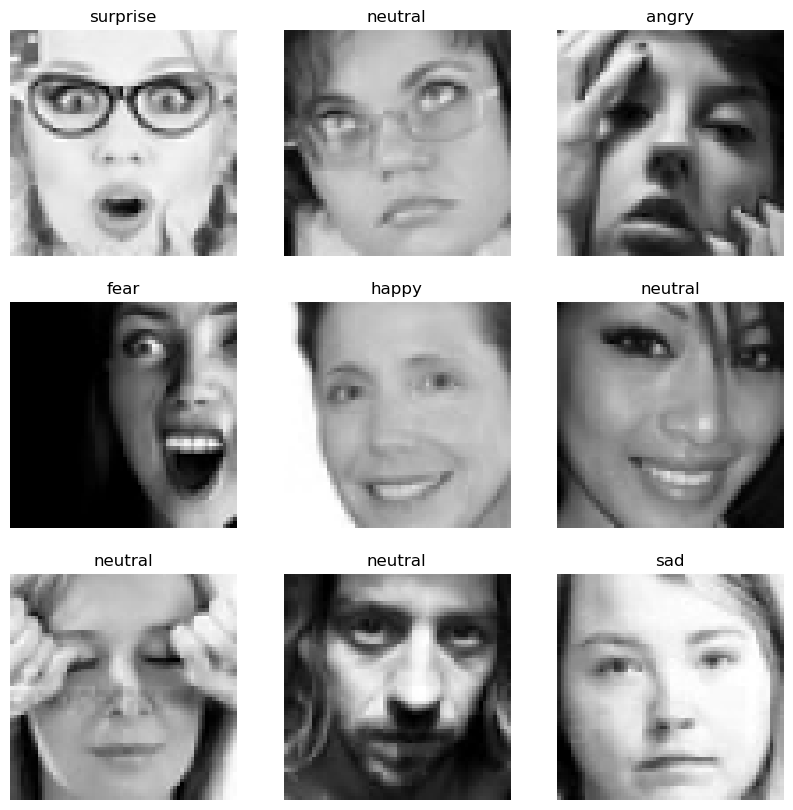

In [41]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
#     plt.title(train_ds.class_names[labels[i]])
    plt.title(test_ds.class_names[np.argmax(labels[i])])
#     print(np.argmax(labels[i]))
    plt.axis("off")

In [42]:
def residual_block(x, filters, strides=1):
    # Shortcut branch
    shortcut = x

    # Main branch
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut branch if strides are different
    if strides != 1 or filters != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

inputs = layers.Input(shape=(64, 64, 3))  # Define the input layer
x = inputs  # Assign the input to x
x = layers.Rescaling(1./255) (x)

# Initial conv layers (modified for smaller input)
x = layers.Conv2D(24, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)  # Reduced kernel size and filters
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

# Stack residual blocks (adjust filter counts as needed)
x = residual_block(x, filters=32, strides=1)
x = residual_block(x, filters=32, strides=1)
x = residual_block(x, filters=64, strides=2)
x = residual_block(x, filters=64, strides=1)
x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128, strides=1)

# Final layers
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(CLASS, activation='softmax')(x)  # Adjust output neurons for your task

model = models.Model(inputs=inputs, outputs=outputs)  # Create the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()],
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 64, 64, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 32, 32, 24)           672       ['rescaling_1[0][0]']         
                                                                                                  
 batch_normalization_16 (Ba  (None, 32, 32, 24)           96        ['conv2d_16[0][0]']           
 tchNormalization)                                                                          

In [43]:
epochs=50
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, mode='max', restore_best_weights=True)]
)

Epoch 1/50
889/889 [==============================] - 76s 73ms/step - loss: 1.5106 - accuracy: 0.4118 - precision_1: 0.6898 - recall_1: 0.1815 - val_loss: 1.6724 - val_accuracy: 0.3328 - val_precision_1: 0.4534 - val_recall_1: 0.1403
Epoch 2/50
889/889 [==============================] - 73s 82ms/step - loss: 1.2628 - accuracy: 0.5172 - precision_1: 0.7320 - recall_1: 0.3098 - val_loss: 1.8100 - val_accuracy: 0.3503 - val_precision_1: 0.4317 - val_recall_1: 0.2104
Epoch 3/50
889/889 [==============================] - 69s 77ms/step - loss: 1.1373 - accuracy: 0.5703 - precision_1: 0.7445 - recall_1: 0.3872 - val_loss: 1.3293 - val_accuracy: 0.5101 - val_precision_1: 0.6381 - val_recall_1: 0.3570
Epoch 4/50
889/889 [==============================] - 62s 69ms/step - loss: 1.0283 - accuracy: 0.6144 - precision_1: 0.7547 - recall_1: 0.4578 - val_loss: 1.9711 - val_accuracy: 0.3684 - val_precision_1: 0.3899 - val_recall_1: 0.3078
Epoch 5/50
889/889 [==============================] - 56s 63ms/s

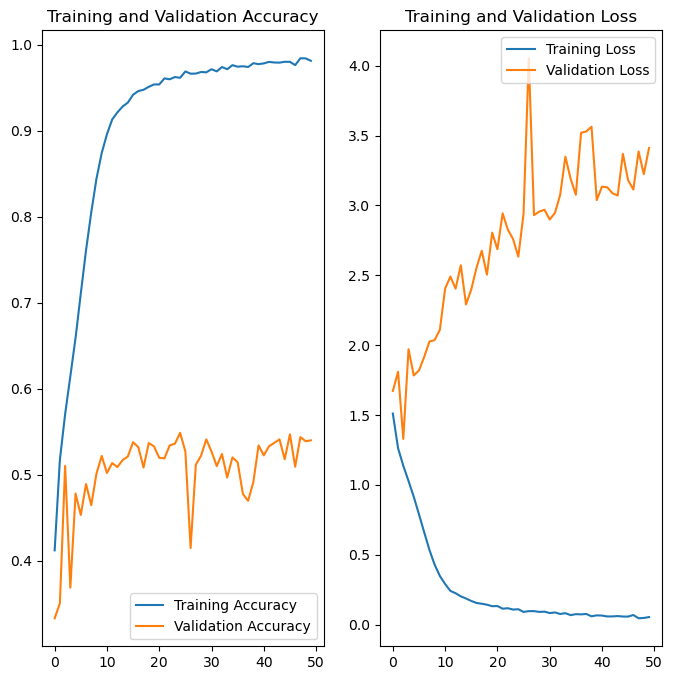

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(val_acc))  # Or len(val_loss), or any validation metric


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
model.save(os.path.join("/content/drive/MyDrive/DL_Final_Proj/untitled"))
model

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL_Final_Proj/untitled\assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL_Final_Proj/untitled\assets


In [46]:
# Create a new model instance
model_loaded = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/DL_Final_Proj/untitled"))
model_loaded.evaluate(test_ds)

223/223 [==============================] - 7s 27ms/step - loss: 3.4111 - accuracy: 0.5398 - precision_1: 0.5461 - recall_1: 0.5332


[3.4110822677612305, 0.5398254990577698, 0.5461227893829346, 0.533211350440979]

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
1/1 [==============================] - 0s 41ms/step


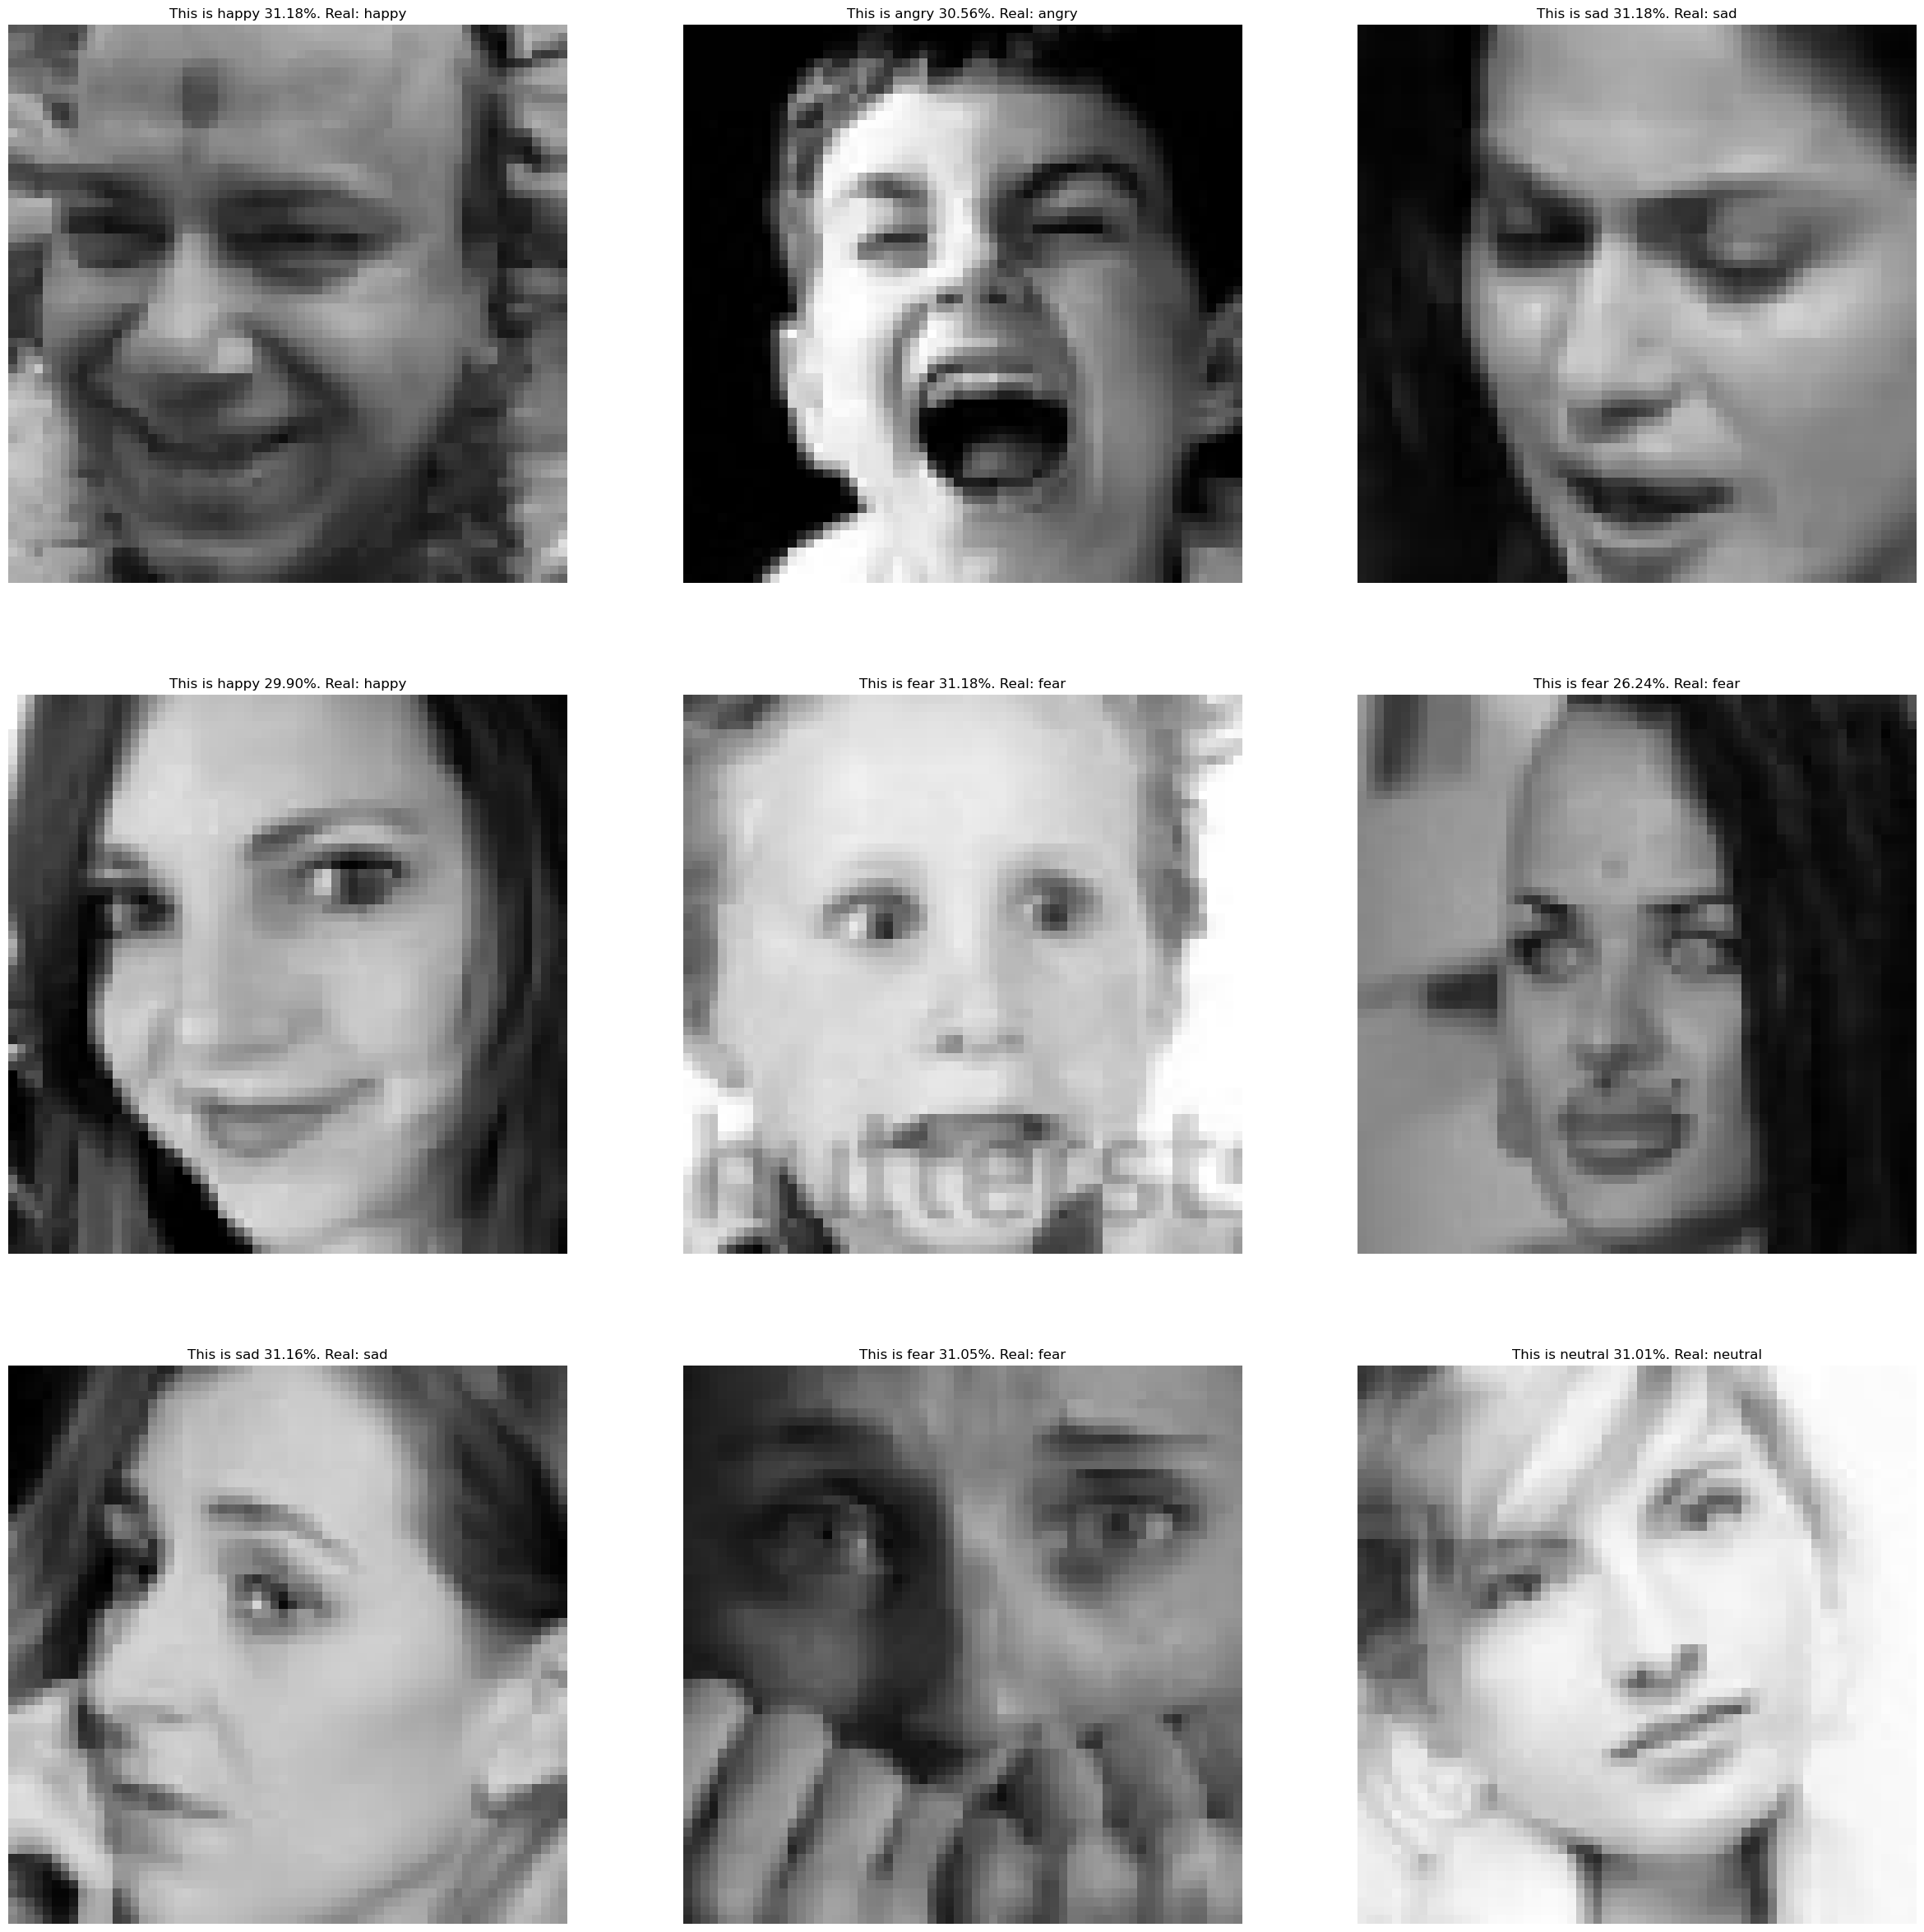

In [47]:
plt.figure(figsize=(30, 30))
for images, labels in test_ds.take(1):
    print(test_ds.class_names)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
#         plt.title(train_ds.class_names[labels[i]])
        img = images[i].numpy().astype("uint8")
#         img = img*1.0/255
#         print(img)
        plt.imshow(img, cmap="gray")
        img_array = np.expand_dims(img, 0)
#         print(img_array)
        predictions = model_loaded.predict(img_array)
#         print(predictions)
        score = tf.nn.softmax(predictions)
#         print(score)
#         predicted_classes = np.argmax(score)
#         print(predicted_classes)
#         print(score)
        plt.title("This is {} {:.2f}%. Real: {}".format(test_ds.class_names[np.argmax(score)], 100 * np.max(score), test_ds.class_names[np.argmax(labels[i])]))
        plt.axis("off")